# Building Regression Models

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import pickle

In [2]:
# Open pickled dataframe from EDA
with open("datasets/anime_normal.p", "rb") as f:
    df = pickle.load(f)
    f.close()
df.head(3)

,rating,average_episode_duration,num_episodes,title_len,synopsis_len,synop_pol,title_pol,synop_subj,title_subj,num_related_anime,...,DLE,J.C.Staff,other_studio,Drama,Shounen,Kids,Mystery,Psychological,Supernatural,other_genres
9,8.98,1500,22,30,802,0.068571,0.0,0.386190,0.0,2,...,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,1
10,8.95,1460,24,17,786,-0.030022,0.0,0.568063,0.0,3,...,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,1.0,1
11,8.95,1494,201,7,680,0.162500,0.0,0.634226,0.0,12,...,0.0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,1


For our model building, we will not consider 'popularity' or 'pic_colorfulness'. The former was used for weights, and the latter was a tested feature in previous models. The features used in this notebook lead to the best results. So, we will remove it and reset our indices. Then, we will create our X and y dataframes, containing our features and target, respectively.

In [3]:
# Popularity is for weights, not a feature, so we remove it and reset indices
df = df.reset_index(drop=True)

# Define features and target
features = ['average_episode_duration', 'num_episodes', 'title_len',
       'synopsis_len', 'synop_pol', 'title_pol', 'synop_subj', 'title_subj',
       'num_related_anime', 'num_genres', 'num_studios',
       'Bones', 'Production I.G', 'A-1 Pictures',
       'Madhouse', 'Kyoto Animation', 'Shaft', 'DLE', 'J.C.Staff',
       'other_studio', 'Drama', 'Shounen', 'Kids', 'Mystery', 'Psychological',
       'Supernatural', 'other_genres', 'source']

target = 'rating'

# Create X and y dataframes
X = df[features]
y = df[target]

# Creating our Preprocessors

In [4]:
# Import preprocessing libraries
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [5]:
cont_cols = ['average_episode_duration', 'num_episodes', 'title_len', 'synopsis_len',
       'synop_pol', 'title_pol', 'synop_subj', 'title_subj',
       'num_related_anime', 'num_genres', 'num_studios']

cat_cols = ['Bones', 'Production I.G', 'A-1 Pictures',
       'Madhouse', 'Kyoto Animation', 'Shaft', 'DLE', 'J.C.Staff',
       'other_studio', 'Drama', 'Shounen', 'Kids', 'Mystery', 'Psychological',
       'Supernatural','other_genres', 'source']

cont_index = [X.columns.get_loc(c) for c in cont_cols]
cat_index = [X.columns.get_loc(c) for c in cat_cols]
source_index = X.columns.get_loc('source')

# Imputation preprocessor; mean for continuous variables, mode for categorical
imp_preproc = ColumnTransformer(remainder='passthrough', transformers=[
    ('imp_cont', SimpleImputer(strategy='mean'), cont_index),
    ('imp_cat', SimpleImputer(strategy='most_frequent'), cat_index),
])

# One hot encodes the "source" feature
source_preproc = ColumnTransformer(remainder='passthrough', transformers=[
    ('ord', OrdinalEncoder(handle_unknown='ignore'), [source_index]),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), [source_index])
])

# Drops the "source" feature, keeping only the dummy columns
drop_preproc = ColumnTransformer(remainder='drop', transformers=[
    ('drop_first', SimpleImputer(strategy='most_frequent'), [i for i in range(1,len(features) + 4)]),
])

# Hyperparameter Tuning

In [6]:
from sklearn.model_selection import GridSearchCV, ParameterGrid, KFold

In [16]:
# Parameter grid for GridSearchCV
model_grid = {
    'linear_reg': {
        'model':LinearRegression(),
        'params': {
            'normalize': [True, False]
        }
    },
    'lasso': {
        'model':Lasso(max_iter=50000),
        'params': {
            # 'alpha': np.logspace(-6, 6, 50)
            'alpha': [0.0006, 0.00065, 0.0007]
        }
    },
    'ridge': {
        'model':Ridge(max_iter=50000),
        'params': {
            # 'alpha': np.logspace(-6, 6, 50)
            'alpha': [2.05, 2.1, 2.15, 2.2, 2.25]
        }
    },
    'random_forest': {
        'model':RandomForestRegressor(random_state=15, n_jobs=3, n_estimators=500),
        'params': {
            'max_depth': [22, 23, 24, 25, 26],
            # 'max_depth': [None, 4, 8, 12, 16, 20, 24, 28],
            'criterion':['mse', 'mae'],
            'max_features':['auto', 'sqrt', 'log2']
        }
    },
    'gradient_boosting': {
        'model': GradientBoostingRegressor(random_state=15),
        'params': {
            'loss': ['ls', 'lad', 'huber'],
            'criterion':['friedman_mse', 'mse'],
            'max_depth': [1, 2, 3, 4],
            'max_features':[None, 'sqrt', 'log2']
            # 'max_depth': [4, 5, 6]
        }
    }
}

# Testing our Models

Although GridSearchCV would be ideal, our target variable has NaN values and must be mean imputed. We want to cross validate as well, so we need to make sure the imputed mean is only for that train set's information. To accomplish this while also iterating through hyperparamter combinations, we will a custom function and for loop.

In [8]:
# Function that helps emulate GridSearchCV, returning average CV score across folds
def CV_score(X, y, splits, model):
    scores = []
    CV_pipe = Pipeline(steps=[
        ('imp_preprocessor', imp_preproc),
        ('source_preprocessor', source_preproc),
        ('drop_preprocessor', drop_preproc),
        ('minmax', MinMaxScaler()),
        ('estimator', model)
    ])

    for train_index, test_index in splits:
        X_train = X.iloc[train_index,:]
        X_test = X.iloc[test_index,:]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        CV_imp = SimpleImputer(strategy='mean', missing_values=np.nan)
        y_train = CV_imp.fit_transform(np.array(y_train).reshape(-1, 1))
        y_test = CV_imp.transform(np.array(y_test).reshape(-1, 1))

        CV_pipe.fit(X_train, y_train.ravel())
        scores.append(CV_pipe.score(X_test, y_test))

    return np.average(scores)

In [17]:
# Contains best score and params for each model type
results = []

for model_name, mp in model_grid.items():
    # Store CV score and the related model_param, indices are the same for a given model
    avg_scores = []
    model_params = []

    # Iterate through parameter grid and apply hyperparamters
    for g in ParameterGrid(mp['params']):
        model = mp['model']
        model.set_params(**g)

        kf = KFold(n_splits=4, shuffle=True, random_state=5)
        splits = kf.split(df)

        # Send X, y, splits, and hyperparam-tuned model to CV_score
        score = CV_score(X, y, splits, model)

        avg_scores.append(score)
        model_params.append(g)

    # Find best score and retrieve its score and params
    best_index = avg_scores.index(np.max(avg_scores))
    results.append({
        'model': model_name,
        'params':model_params[best_index],
        'score': avg_scores[best_index],
    })
    print(model_name, avg_scores)

results

linear_reg [0.3789178086195883, 0.3791539015543023]
lasso [0.38038964600773734, 0.38039514184783824, 0.3803787157286118]
ridge [0.3802400467206387, 0.38024103316747027, 0.38024098337909756, 0.38023991342968055, 0.380237839149527]
random_forest [0.42597282415921645, 0.45294211016943753, 0.45287750320256165, 0.4252192919818937, 0.4530915466690612, 0.4531081495413487, 0.42569331859010096, 0.4538675720438048, 0.45434440133184806, 0.4254293122280719, 0.45396133183450427, 0.45370824300451423, 0.42564481557310524, 0.45431720713602286, 0.4539278248354879, 0.4283105741655663, 0.4514601227706704, 0.4530702707630341, 0.4278359970613277, 0.4514227531122971, 0.45007917540366876, 0.42866941775046996, 0.4515132558183599, 0.44935774404257844, 0.42689636616603444, 0.4520941926967735, 0.451395424652542, 0.4269315901691318, 0.4522470913312723, 0.4505872430123252]
gradient_boosting [0.388905892695089, 0.38941443764698386, 0.3875208088791895, 0.4410613391765463, 0.435122223308261, 0.42961185956034065, 0.45

[{'model': 'linear_reg',
  'params': {'normalize': False},
  'score': 0.3791539015543023},
 {'model': 'lasso',
  'params': {'alpha': 0.00065},
  'score': 0.38039514184783824},
 {'model': 'ridge', 'params': {'alpha': 2.1}, 'score': 0.38024103316747027},
 {'model': 'random_forest',
  'params': {'criterion': 'mse', 'max_depth': 24, 'max_features': 'log2'},
  'score': 0.45434440133184806},
 {'model': 'gradient_boosting',
  'params': {'criterion': 'friedman_mse',
   'loss': 'ls',
   'max_depth': 4,
   'max_features': 'log2'},
  'score': 0.46119552635440225}]

# Feature Importance in the Linear Regressor

Although the random forest and gradient boosting regressor scored the best, we will build a lasso and ridge regressor to observe what coefficients they used during training. Each addresses regularization differently. Where a linear model minimizes the sum of residual squares (RSS), Lasso and Ridge minimize:

### Ridge (L2):  $RSS + \lambda \Sigma \beta^2_j$

### Lasso (L1):  $RSS + \lambda \Sigma |\beta_j|$

When $\lambda = 0$, the models just do normal linear regression. Ridge minimizes coefficients as much as possible, whereas Lasso does so with the ability to remove features entirely (assigning a coefficient of zero)

In [11]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import mean_squared_error, median_absolute_error

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

test_imp = SimpleImputer(strategy='mean', missing_values=np.nan)
y_train = test_imp.fit_transform(np.array(y_train).reshape(-1, 1))
y_test = test_imp.transform(np.array(y_test).reshape(-1, 1))

las_pipe = Pipeline(steps=[
        ('imp_preprocessor', imp_preproc),
        ('source_preprocessor', source_preproc),
        ('drop_preprocessor', drop_preproc),
        ('minmax', MinMaxScaler()),
        ('estimator', Lasso(max_iter=50000, alpha=0.00065))
    ])

rid_pipe = Pipeline(steps=[
        ('imp_preprocessor', imp_preproc),
        ('source_preprocessor', source_preproc),
        ('drop_preprocessor', drop_preproc),
        ('minmax', MinMaxScaler()),
        ('estimator', Ridge(max_iter=50000, alpha=2.1))
    ])

las_pipe.fit(X_train, y_train)
rid_pipe.fit(X_train, y_train)

print("LASSO REGRESSOR\n==============")
print("R2 Value: ", las_pipe.score(X_test, y_test))
print("Mean Squared Error: ", mean_squared_error(y_test, las_pipe.predict(X_test)))
print("Median Absolute Error: ", median_absolute_error(y_test, las_pipe.predict(X_test)))

print("\nRIDGE REGRESSOR\n==============")
print("R2 Value: ", rid_pipe.score(X_test, y_test))
print("Mean Squared Error: ", mean_squared_error(y_test, rid_pipe.predict(X_test)))
print("Median Absolute Error: ", median_absolute_error(y_test, rid_pipe.predict(X_test)))

LASSO REGRESSOR
R2 Value:  0.39512737009298415
Mean Squared Error:  0.36603841856474695
Median Absolute Error:  0.40080915684712437

RIDGE REGRESSOR
R2 Value:  0.3958125572900044
Mean Squared Error:  0.3656237778195431
Median Absolute Error:  0.40334282518704345


In [26]:
new_features = list(las_pipe.named_steps['source_preprocessor'].transformers_[1][1].categories_[0]) + features
new_features.remove('source')

df_feature_importance = pd.DataFrame({
    'Features': new_features,
    'Lasso Coeff': las_pipe.named_steps['estimator'].coef_,
    'Lasso ABS(Coeff)': abs(las_pipe.named_steps['estimator'].coef_),
    'Ridge Coeff': rid_pipe.named_steps['estimator'].coef_[0],
    'Ridge ABS(Coeff)': abs(rid_pipe.named_steps['estimator'].coef_[0])
}).set_index('Features').sort_values('Ridge ABS(Coeff)', ascending=False)
df_feature_importance

,Lasso Coeff,Lasso ABS(Coeff),Ridge Coeff,Ridge ABS(Coeff)
Features,,,,
num_related_anime,1.517265,1.517265,1.427790,1.427790
average_episode_duration,1.317156,1.317156,1.273776,1.273776
synopsis_len,1.155496,1.155496,1.134608,1.134608
Kyoto Animation,0.710683,0.710683,0.750376,0.750376
Production I.G,0.582617,0.582617,0.616828,0.616828
Bones,0.571507,0.571507,0.610732,0.610732
A-1 Pictures,0.448017,0.448017,0.483959,0.483959
Madhouse,0.416136,0.416136,0.447270,0.447270
num_studios,-0.397097,0.397097,-0.445387,0.445387


Generally, the importance between Lasso and Ridge agree. Features like num_related_anime and average_episode_duration seem to have very high importance, where others like title subjectivity or the source being an "original" matters very little.

## Residual Plot

To check how biased the model is, we'll check if the distribution of residuals is normal or not. Ideally, we want the residuals to be close to zero and have a normal distribution.

C:\Users\Brennan\anaconda3\envs\mal\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Brennan\anaconda3\envs\mal\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


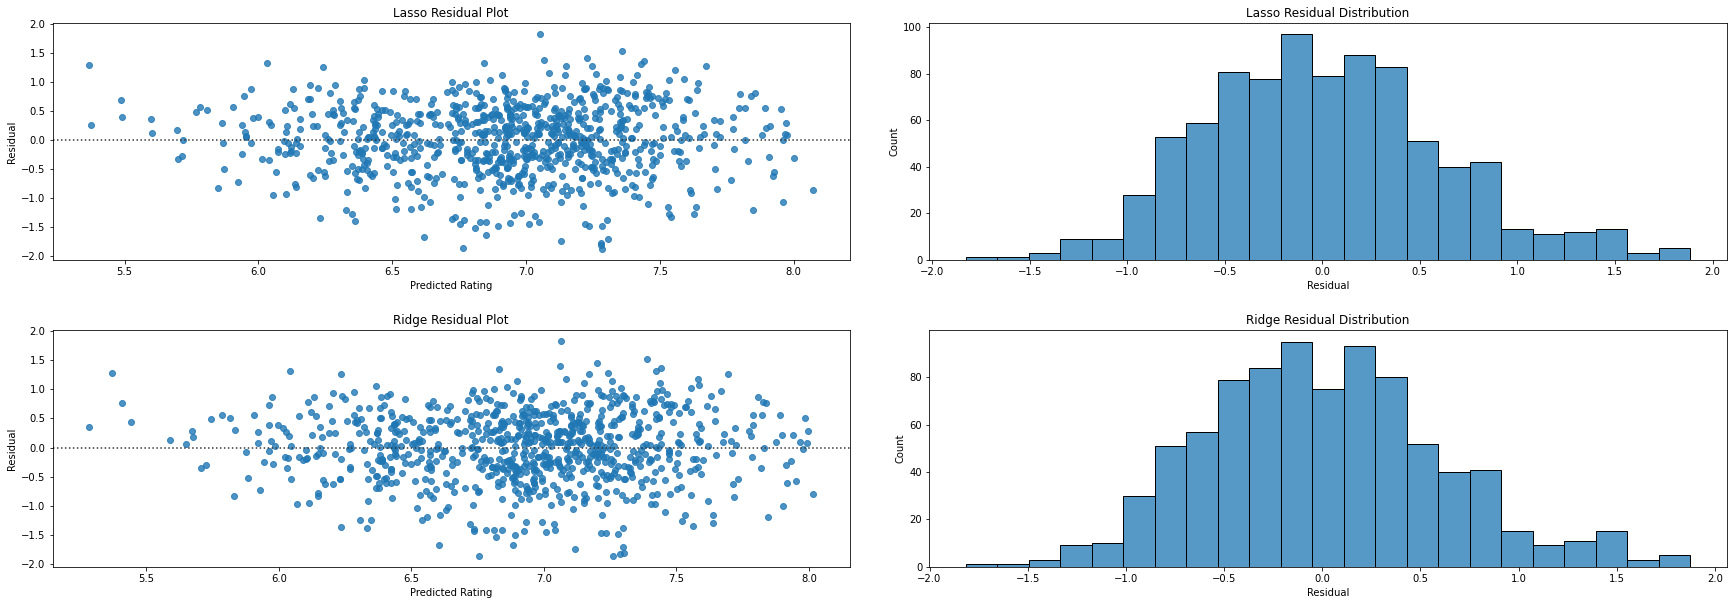

In [27]:
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams['figure.subplot.wspace'] = 0.1
plt.rcParams['figure.subplot.hspace'] = 0.3

fig = plt.figure()

ax = fig.add_subplot(2, 2, 1)
ax.set(xlabel="Predicted Rating", ylabel="Residual", title="Lasso Residual Plot")
sns.residplot(las_pipe.predict(X_test), y_test, ax=ax)

ax = fig.add_subplot(2, 2, 2)
ax.set(xlabel="Residual", title="Lasso Residual Distribution")
sns.histplot(las_pipe.predict(X_test) - y_test.ravel(), ax=ax)

ax = fig.add_subplot(2, 2, 3)
ax.set(xlabel="Predicted Rating", ylabel="Residual", title="Ridge Residual Plot")
sns.residplot(rid_pipe.predict(X_test), y_test, ax=ax)

ax = fig.add_subplot(2, 2, 4)
ax.set(xlabel="Residual", title="Ridge Residual Distribution")
sns.histplot((rid_pipe.predict(X_test) - y_test).ravel(), ax=ax)

plt.show()

As we can see, the residuals are normally distributed.

# Choosing Our Best Model

## Dummy Regressor

We will create a dummy regressor to compare our models to, which will solely predict the mean of the data.

In [10]:
from sklearn.dummy import DummyRegressor

dummy_pipe = Pipeline(steps=[
        ('imp_preprocessor', imp_preproc),
        ('source_preprocessor', source_preproc),
        ('drop_preprocessor', drop_preproc),
        ('minmax', MinMaxScaler()),
        ('estimator', DummyRegressor())
    ])

dummy_pipe.fit(X_train, y_train)
print("R2 Value: ", dummy_pipe.score(X_test, y_test))
print("Mean Squared Error: ", mean_squared_error(y_test, dummy_pipe.predict(X_test)))
print("Median Absolute Error: ", median_absolute_error(y_test, dummy_pipe.predict(X_test)))

R2 Value:  -0.0001288941985411185
Mean Squared Error:  0.6052275813002478
Median Absolute Error:  0.5168376068376066


## Random Forest Regressor and Gradient Boost Regressor

Now we will create our random forest and gradient boost regressor, check the scores, and check the residuals.

In [24]:
rantree_pipe = Pipeline(steps=[
        ('imp_preprocessor', imp_preproc),
        ('source_preprocessor', source_preproc),
        ('drop_preprocessor', drop_preproc),
        ('minmax', MinMaxScaler()),
        ('estimator', RandomForestRegressor(random_state=15, n_jobs=3, n_estimators=1000, criterion='mse', max_depth=24, max_features='log2'))
    ])

gboost_pipe = Pipeline(steps=[
        ('imp_preprocessor', imp_preproc),
        ('source_preprocessor', source_preproc),
        ('drop_preprocessor', drop_preproc),
        ('minmax', MinMaxScaler()),
        ('estimator', GradientBoostingRegressor(random_state=15, criterion='friedman_mse', loss='huber', max_depth=4, max_features='log2'))
    ])

rantree_pipe.fit(X_train, y_train.ravel())
gboost_pipe.fit(X_train, y_train.ravel())

print("RANDOM FOREST REGRESSOR\n==============")
print("R2 Value: ", rantree_pipe.score(X_test, y_test))
print("Mean Squared Error: ", mean_squared_error(y_test, rantree_pipe.predict(X_test)))
print("Median Absolute Error: ", median_absolute_error(y_test, rantree_pipe.predict(X_test)))

print("\nGRADIENT BOOST REGRESSOR\n==============")
print("R2 Value: ", gboost_pipe.score(X_test, y_test))
print("Mean Squared Error: ", mean_squared_error(y_test, gboost_pipe.predict(X_test)))
print("Median Absolute Error: ", median_absolute_error(y_test, gboost_pipe.predict(X_test)))

RANDOM FOREST REGRESSOR
R2 Value:  0.47409084160420634
Mean Squared Error:  0.31825370686305626
Median Absolute Error:  0.3616112499999966

GRADIENT BOOST REGRESSOR
R2 Value:  0.4902863651287127
Mean Squared Error:  0.30845299258763964
Median Absolute Error:  0.35161755710710896


# Checking the Residuals

C:\Users\Brennan\anaconda3\envs\mal\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Brennan\anaconda3\envs\mal\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


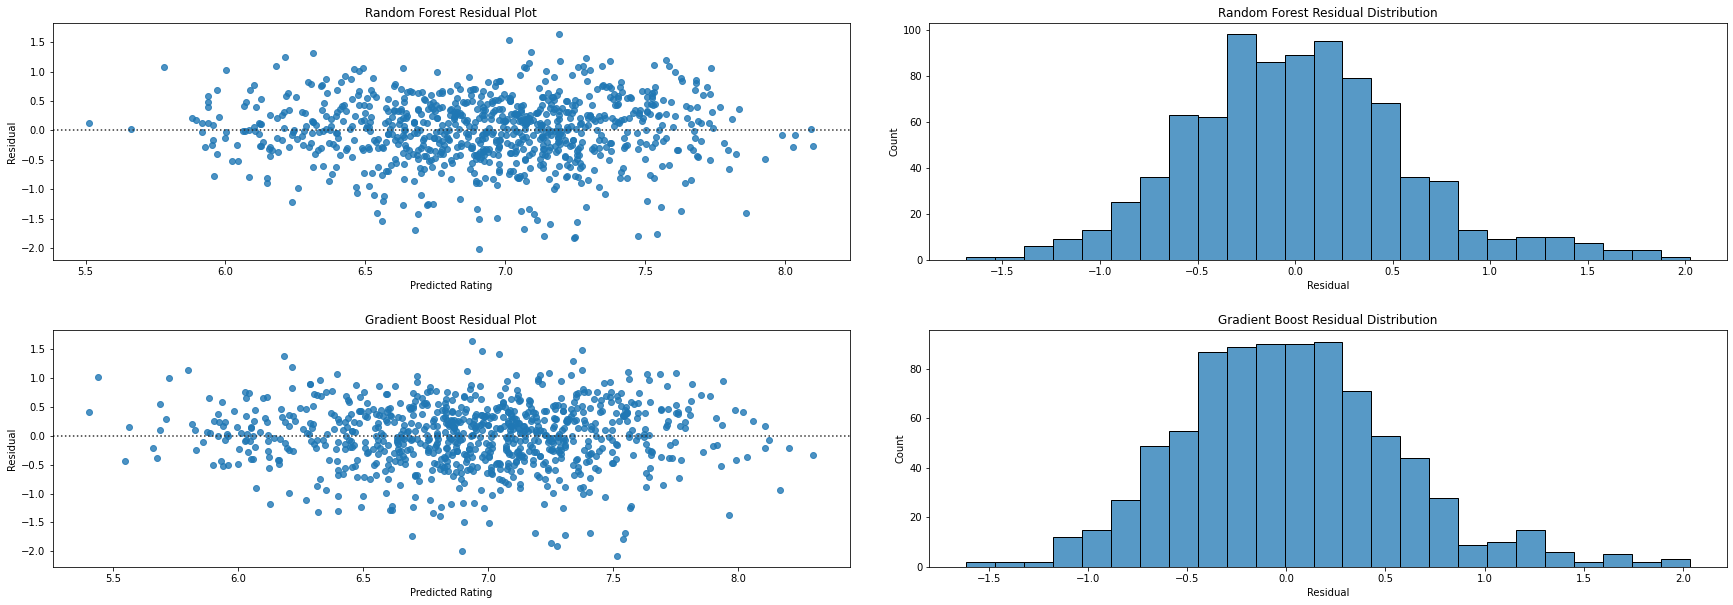

In [25]:
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams['figure.subplot.wspace'] = 0.1
plt.rcParams['figure.subplot.hspace'] = 0.3

fig = plt.figure()

ax = fig.add_subplot(2, 2, 1)
ax.set(xlabel="Predicted Rating", ylabel="Residual", title="Random Forest Residual Plot")
sns.residplot(rantree_pipe.predict(X_test), y_test, ax=ax)

ax = fig.add_subplot(2, 2, 2)
ax.set(xlabel="Residual", title="Random Forest Residual Distribution")
sns.histplot(rantree_pipe.predict(X_test) - y_test.ravel(), ax=ax)

ax = fig.add_subplot(2, 2, 3)
ax.set(xlabel="Predicted Rating", ylabel="Residual", title="Gradient Boost Residual Plot")
sns.residplot(gboost_pipe.predict(X_test), y_test, ax=ax)

ax = fig.add_subplot(2, 2, 4)
ax.set(xlabel="Residual", title="Gradient Boost Residual Distribution")
sns.histplot(gboost_pipe.predict(X_test) - y_test.ravel(), ax=ax)

plt.show()

So, our models resulted in much better $R^2$ scores while maintaining normality. **We will take the Gradient Boosting Regressor as our model,** as it minimized the MSE and MAE the most among all models.

# Saving Our Model

In [28]:
import gzip, pickletools

# The output of a regular pickle.dump for our random forest is quite large,
# we can compress it using gzip
with gzip.open("server/artifacts/gboost_pipe.pickle", "wb") as f:
    pickled = pickle.dumps(gboost_pipe)
    optimized_pickle = pickletools.optimize(pickled)
    f.write(optimized_pickle)
    f.close()

# """Code for loading from a gzipped pickle file"""
# with gzip.open("server/artifacts/gboost_pipe.pickle", 'rb') as f:
#     p = pickle.Unpickler(f)
#     gboost_pipe = p.load()

In [29]:
import json

# Firstly we append our data columns to the json
column_info = {
    'data_columns' : features
}

# Write dict to a json file
with open("server/artifacts/data_columns.json", "w") as f:
    f.write(json.dumps(column_info))

In [30]:
new_features = list(gboost_pipe.named_steps['source_preprocessor'].transformers_[1][1].categories_[0]) + features
new_features.remove('source')

df_feature_importance = pd.DataFrame({
    'Features': new_features,
    'GBoost Coeff': gboost_pipe.named_steps['estimator'].feature_importances_,
}).sort_values('GBoost Coeff', ascending=False)
df_feature_importance.style.bar(subset=['GBoost Coeff'], color='grey')

,Features,GBoost Coeff
7,synopsis_len,0.200139
4,average_episode_duration,0.148603
12,num_related_anime,0.104641
13,num_genres,0.079722
5,num_episodes,0.054571
14,num_studios,0.047386
24,Drama,0.044788
26,Kids,0.039961
0,manga,0.036482
3,other,0.033544


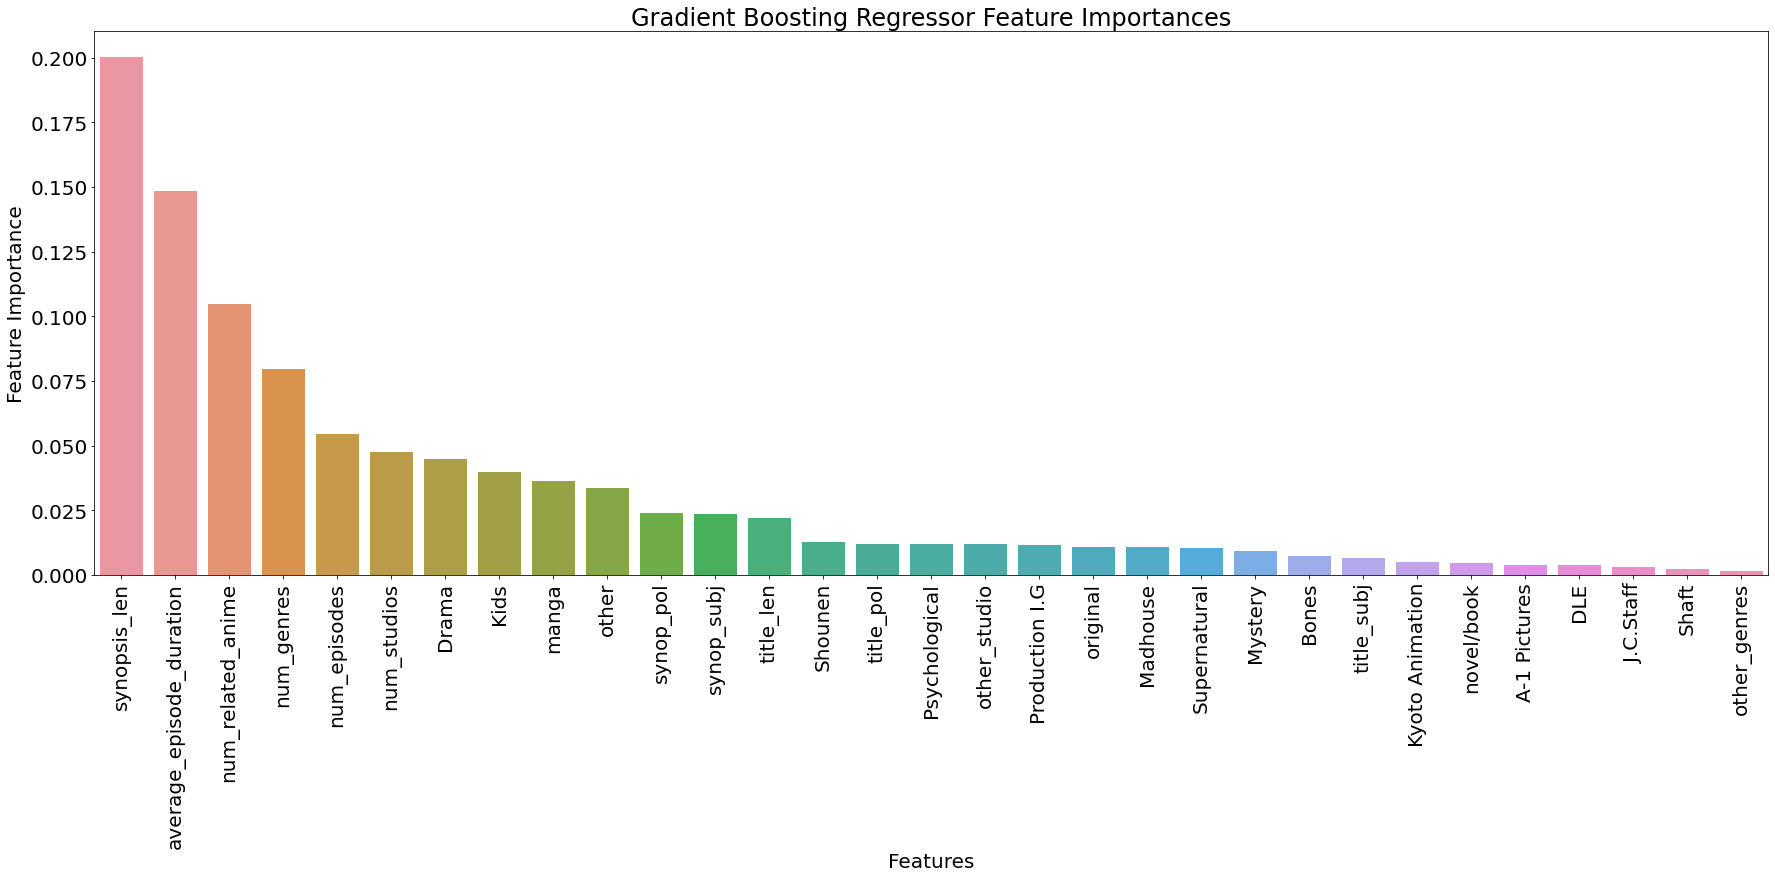

In [32]:
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams['figure.subplot.wspace'] = 0.1
plt.rcParams['figure.subplot.hspace'] = 0.3
plt.rc('font', size=20)
coef_plot = sns.barplot(data=df_feature_importance, x='Features', y='GBoost Coeff')
coef_plot.set(
    ylabel="Feature Importance", title="Gradient Boosting Regressor Feature Importances")
coef_plot.set_xticklabels(coef_plot.get_xticklabels(), rotation=90)
plt.show()